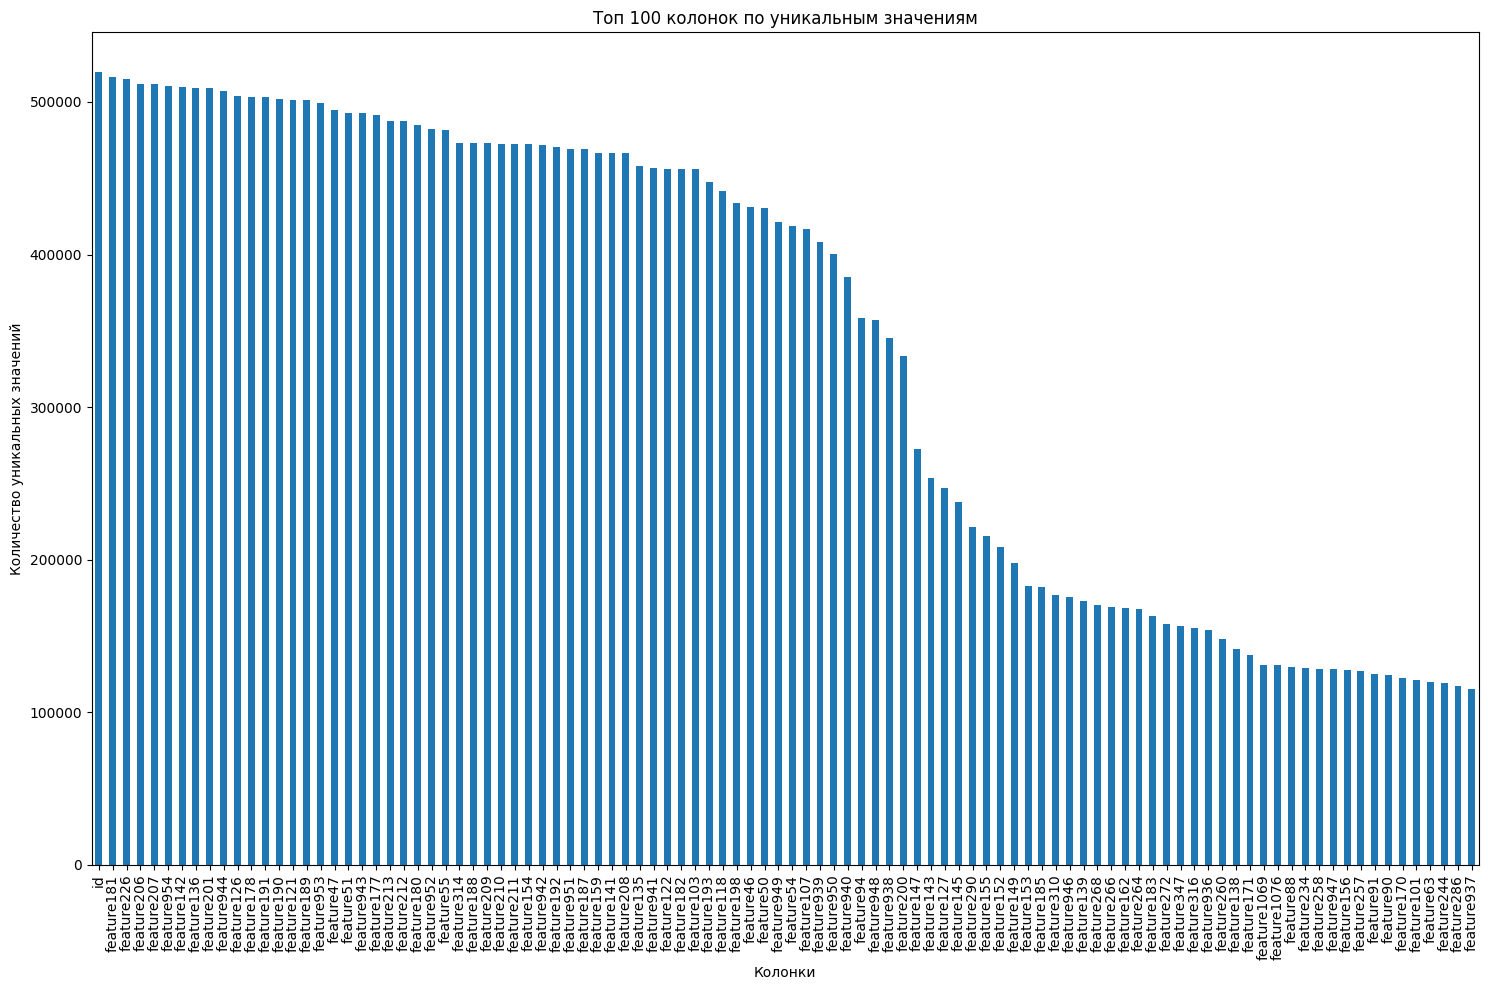

In [15]:
# ================== Загрузка и анализ данных ==================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import warnings
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import clone
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')

data = pd.read_parquet('train_ai_comp_final_dp.parquet')

for col in data.columns:
    if data[col].dtype == 'int64':
        data[col] = data[col].astype('int32')
    elif data[col].dtype == 'float64':
        data[col] = data[col].astype('float32')
    elif data[col].dtype == 'object':
        if len(data[col].unique()) / len(data[col]) < 0.5:
            data[col] = data[col].astype('category')

# Анализ уникальных значений
unique_counts = data.nunique().sort_values(ascending=False)
top_100_cols = unique_counts.head(100)

plt.figure(figsize=(15,10))
top_100_cols.plot(kind='bar')
plt.ylabel('Количество уникальных значений')
plt.xlabel('Колонки')
plt.title('Топ 100 колонок по уникальным значениям')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




In [16]:
data.head()

,id,target,sample_ml_new,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
0,0,0,1,1761,1759,85,105469,191,46,0,...,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264
1,1,0,1,1761,1759,120,105610,144,71,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,890,1759,141,105227,191,11,0,...,55949,70006,113317,33735,31242,12691,48682,55949,70006,113317
5,5,0,1,1599,966,30,102441,191,8,0,...,0,6872,8530,0,0,0,0,0,6872,8530
6,6,0,1,1761,1759,85,104006,191,2,0,...,0,0,7642,0,0,0,0,0,0,7642


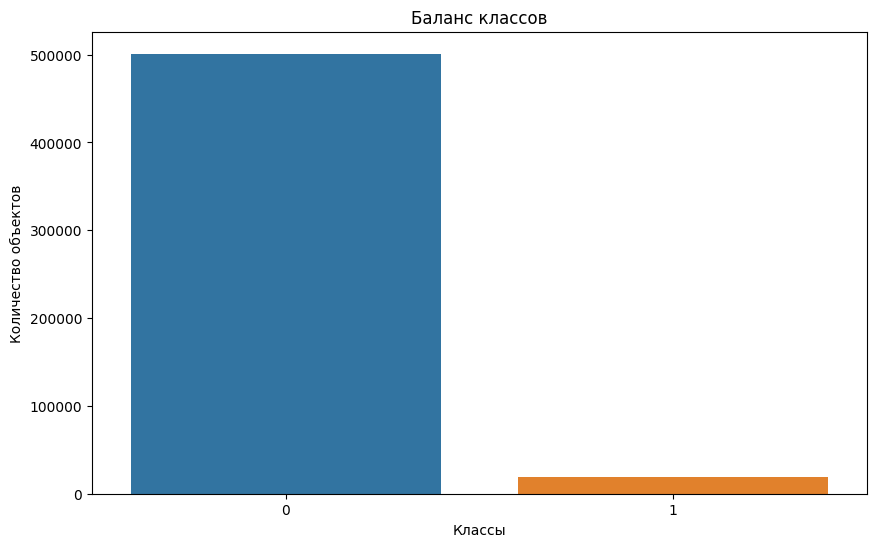

In [17]:
# Баланс классов
class_counts = data['target'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=data)
plt.xlabel('Классы')
plt.ylabel('Количество объектов')
plt.title('Баланс классов')
plt.show()

Get correlated features: 100%|██████████| 886/886 [00:00<00:00, 8433.42it/s]


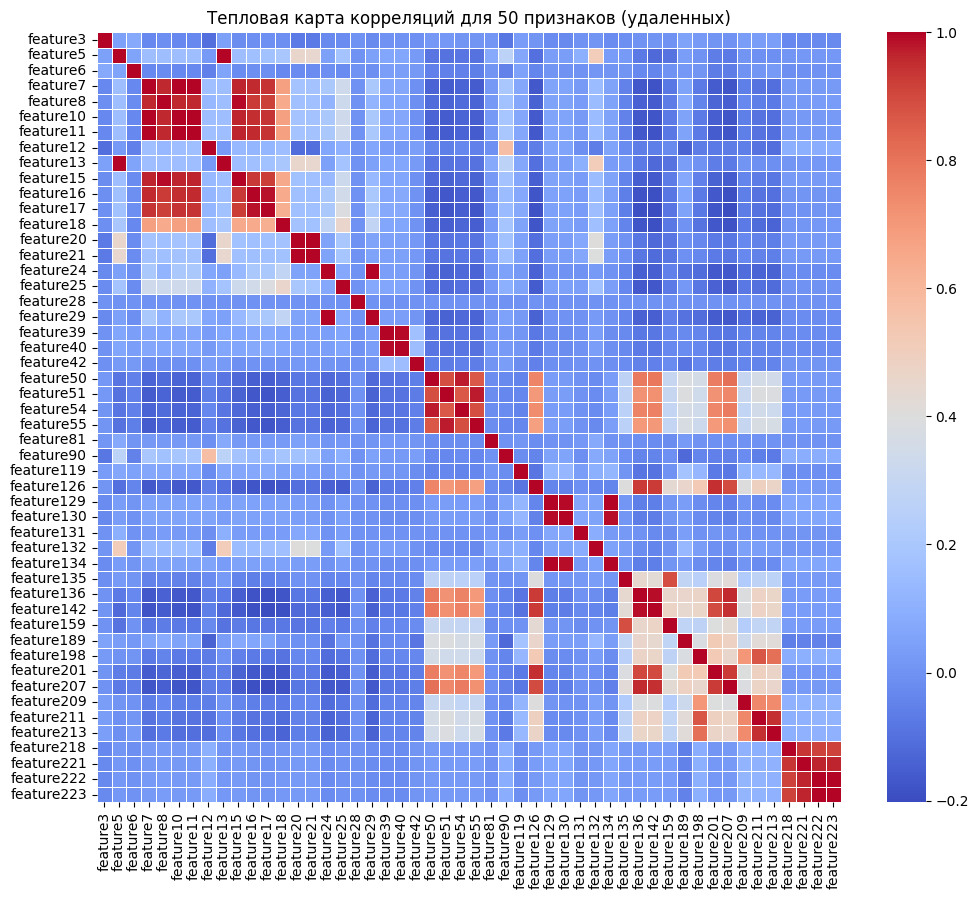

In [18]:
# ================== Обработка данных и инжиниринг признаков ==================
def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.9):
    from tqdm import tqdm
    cols = corr_matrix.columns.to_list()
    dropped = {col: 0 for col in cols}
    for col in tqdm(cols, desc='Get correlated features'):
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            if len(columns_to_check) > 1:
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()

                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1

                for bad_col in bad_cols:
                    dropped[bad_col] += 1
    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

clean_df = data.copy()
nan_percentage = (clean_df == 0).mean()
cols_to_drop = list(nan_percentage[nan_percentage > 0.95].index)

ignore_features = ['id', 'target', 'sample_ml_new', 'feature756'] + cols_to_drop
clean_df = clean_df.drop(columns=ignore_features)

corr_mx = pd.DataFrame(np.corrcoef(clean_df.values, rowvar=False), columns=clean_df.columns, index=clean_df.columns)
corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.95)

correlated = data[corr_feats]
selected_features = correlated.columns[:50]
correlation_matrix = correlated[selected_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Тепловая карта корреляций для 50 признаков (удаленных)')
plt.show()

df_no_corr = clean_df.drop(columns=corr_feats)
df_no_corr['target'] = data['target']
df_no_corr = df_no_corr.reset_index(drop=True)



def generate_new_features(df):
    # Преобразования для существующих фичей
    df['sin_feature341'] = np.sin(df['feature341'])
    df['log_feature940'] = np.log1p(df['feature940'])
    df['interaction1'] = df['feature1004'] * df['feature994']

    # Дополнительные преобразования
    df['cos_feature341'] = np.cos(df['feature341'])
    df['sqrt_feature952'] = np.sqrt(df['feature952'])
    df['interaction2'] = df['feature318'] / (df['feature943'] + 1e-6)  

    # Статистические фичи
    feature_cols = ['feature1004', 'feature318', 'feature341', 'feature994', 'feature952',
                    'feature944', 'feature320', 'feature1000', 'feature943', 'feature993']
    
    df['mean_feature'] = df[feature_cols].mean(axis=1)
    df['std_feature'] = df[feature_cols].std(axis=1)
    df['median_feature'] = df[feature_cols].median(axis=1)

    # Полиномиальные фичи
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    features_to_poly = df[['feature1004', 'feature318', 'feature341', 'feature994', 'feature952',
                           'feature944', 'feature320', 'feature1000', 'feature943', 'feature993',
                           'interaction1', 'sin_feature341', 'log_feature940', 'cos_feature341',
                           'sqrt_feature952', 'interaction2', 'mean_feature', 'std_feature', 'median_feature']]
    poly_features = poly.fit_transform(features_to_poly)
    poly_feature_names = [f'poly_{i}' for i in range(poly_features.shape[1])]
    X_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

    # Соединение исходных данных с новыми фичами
    df = pd.concat([df, X_poly], axis=1)
    return df

df_no_corr = generate_new_features(df_no_corr)
X = df_no_corr.drop(columns=['target'])
y = df_no_corr['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [19]:
import optuna
from optuna.samplers import TPESampler

In [20]:
# Оптимизация гиперпараметров с использованием Optuna
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 3000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
#         'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0),
#         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-3, 10.0),
#         'border_count': trial.suggest_int('border_count', 1, 255),
#         'bootstrap_type': 'Bernoulli',
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'class_weights': [1, 10],
#         'eval_metric': 'AUC',
#         'random_seed': 42,
#         'verbose': 0,
#         'loss_function': 'Logloss'
#     }

#     model = CatBoostClassifier(**params)
#     model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=0)
#     y_pred = model.predict_proba(X_test)[:, 1]
#     auc = roc_auc_score(y_test, y_pred)
#     return auc

# study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
# study.optimize(objective, n_trials=50)

# best_params = study.best_params
# best_params['eval_metric'] = 'AUC'
# best_params['random_seed'] = 42
# best_params['verbose'] = 200
# best_params['loss_function'] = 'Logloss'


0:	learn: 0.6834188	total: 222ms	remaining: 9m 50s
500:	learn: 0.4984511	total: 1m 41s	remaining: 7m 16s
1000:	learn: 0.4708875	total: 3m 28s	remaining: 5m 44s
1500:	learn: 0.4505963	total: 5m 16s	remaining: 4m 2s
2000:	learn: 0.4325923	total: 7m 6s	remaining: 2m 19s
2500:	learn: 0.4156306	total: 8m 58s	remaining: 32.9s
2653:	learn: 0.4107646	total: 9m 33s	remaining: 0us


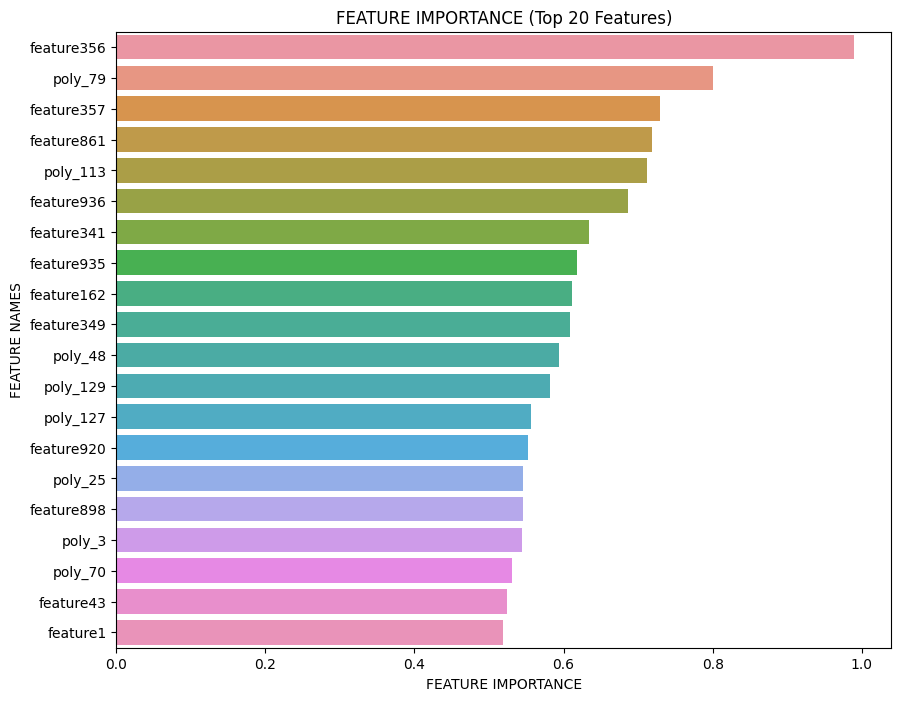

In [21]:
# ================== Модель отбора признаков ==================
# Оптимизированные параметры
params = {
    'iterations': 2654,
    'learning_rate': 0.03354989749053529,
    'depth': 5,
    'l2_leaf_reg': 9.633986278110502,
    'random_strength': 8.976484608530859,
    'bagging_temperature': 0.44428949970755705,
    'border_count': 158,
    'verbose': 500,
    'class_weights': [1, 10]
}

# Функция для отбора важных признаков
def select_important_features(X, y):
    model = CatBoostClassifier(**params)
    model.fit(X, y)
    selector = SelectFromModel(model, prefit=True, threshold="mean")
    X_important = selector.transform(X)
    selected_features = X.columns[selector.get_support()]
    return model, X_important, selected_features

model, X_train_selected, selected_features = select_important_features(X_train, y_train)

# Применение отбора признаков к тестовому набору
X_test_selected = X_test[selected_features]

# Визуализация важности признаков
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df[importance_df['Feature'].isin(selected_features)]
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('FEATURE IMPORTANCE (Top 20 Features)')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')
plt.show()

In [22]:
# ================== Модель обучения и стэкинга ==================
class SoftVotingClassifier:
    def __init__(self, estimators):
        self.estimators = estimators

    def fit(self, X, y):
        self.estimators_ = [clone(estimator) for estimator in self.estimators]
        for estimator in self.estimators_:
            estimator.fit(X, y)
        return self

    def predict_proba(self, X):
        all_proba = np.asarray([estimator.predict_proba(X) for estimator in self.estimators_])
        avg_proba = np.mean(all_proba, axis=0)
        return avg_proba

    def predict(self, X):
        avg_proba = self.predict_proba(X)
        return np.argmax(avg_proba, axis=1)

# Создание и оценка модели стэкинга с использованием различных наборов данных
def create_stacking_model(X, y):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index].values, y.iloc[val_index].values
        
        model = CatBoostClassifier(**{**params, 'random_seed': 42 + i})
        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), verbose=500)
        models.append(model)
    
    stacking_model = SoftVotingClassifier(models)
    stacking_model.fit(X, y)
    return stacking_model

stacking_model = create_stacking_model(X_train_selected, y_train)
predictions = stacking_model.predict(X_test_selected)
predictions_proba = stacking_model.predict_proba(X_test_selected)

print(f"Precision Score: {precision_score(y_test, predictions)}")
print(f"Recall Score: {recall_score(y_test, predictions)}")
print(f"F1 Score: {f1_score(y_test, predictions)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, predictions_proba[:, 1])}")

0:	learn: 0.6822604	test: 0.6823824	best: 0.6823824 (0)	total: 64ms	remaining: 2m 49s
500:	learn: 0.4926147	test: 0.5047008	best: 0.5047008 (500)	total: 27.8s	remaining: 1m 59s
1000:	learn: 0.4578213	test: 0.4988584	best: 0.4988578 (999)	total: 54.1s	remaining: 1m 29s
1500:	learn: 0.4302226	test: 0.4991876	best: 0.4986964 (1147)	total: 1m 21s	remaining: 1m 2s
2000:	learn: 0.4056944	test: 0.5000730	best: 0.4986964 (1147)	total: 1m 50s	remaining: 35.9s
2500:	learn: 0.3835509	test: 0.5024702	best: 0.4986964 (1147)	total: 2m 24s	remaining: 8.85s
2653:	learn: 0.3771248	test: 0.5032057	best: 0.4986964 (1147)	total: 2m 34s	remaining: 0us

bestTest = 0.4986964232
bestIteration = 1147

Shrink model to first 1148 iterations.
0:	learn: 0.6824106	test: 0.6824019	best: 0.6824019 (0)	total: 64ms	remaining: 2m 49s
500:	learn: 0.4943349	test: 0.5021564	best: 0.5021564 (500)	total: 34.5s	remaining: 2m 28s
1000:	learn: 0.4598879	test: 0.4961189	best: 0.4960627 (979)	total: 1m 8s	remaining: 1m 52s
1500:	

In [24]:
from sklearn.metrics import roc_curve, auc

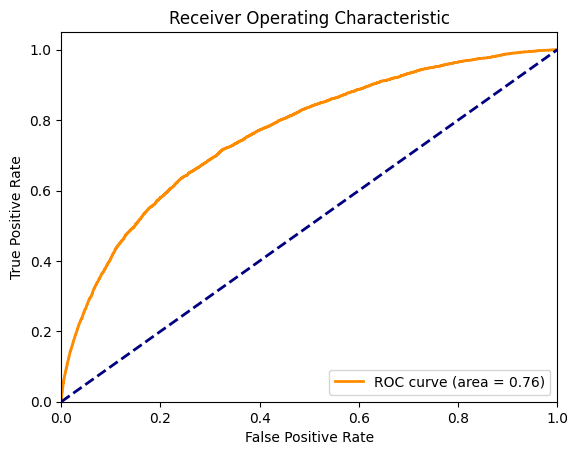

In [26]:
fpr, tpr, _ = roc_curve(y_test, predictions_proba[:, 1])
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

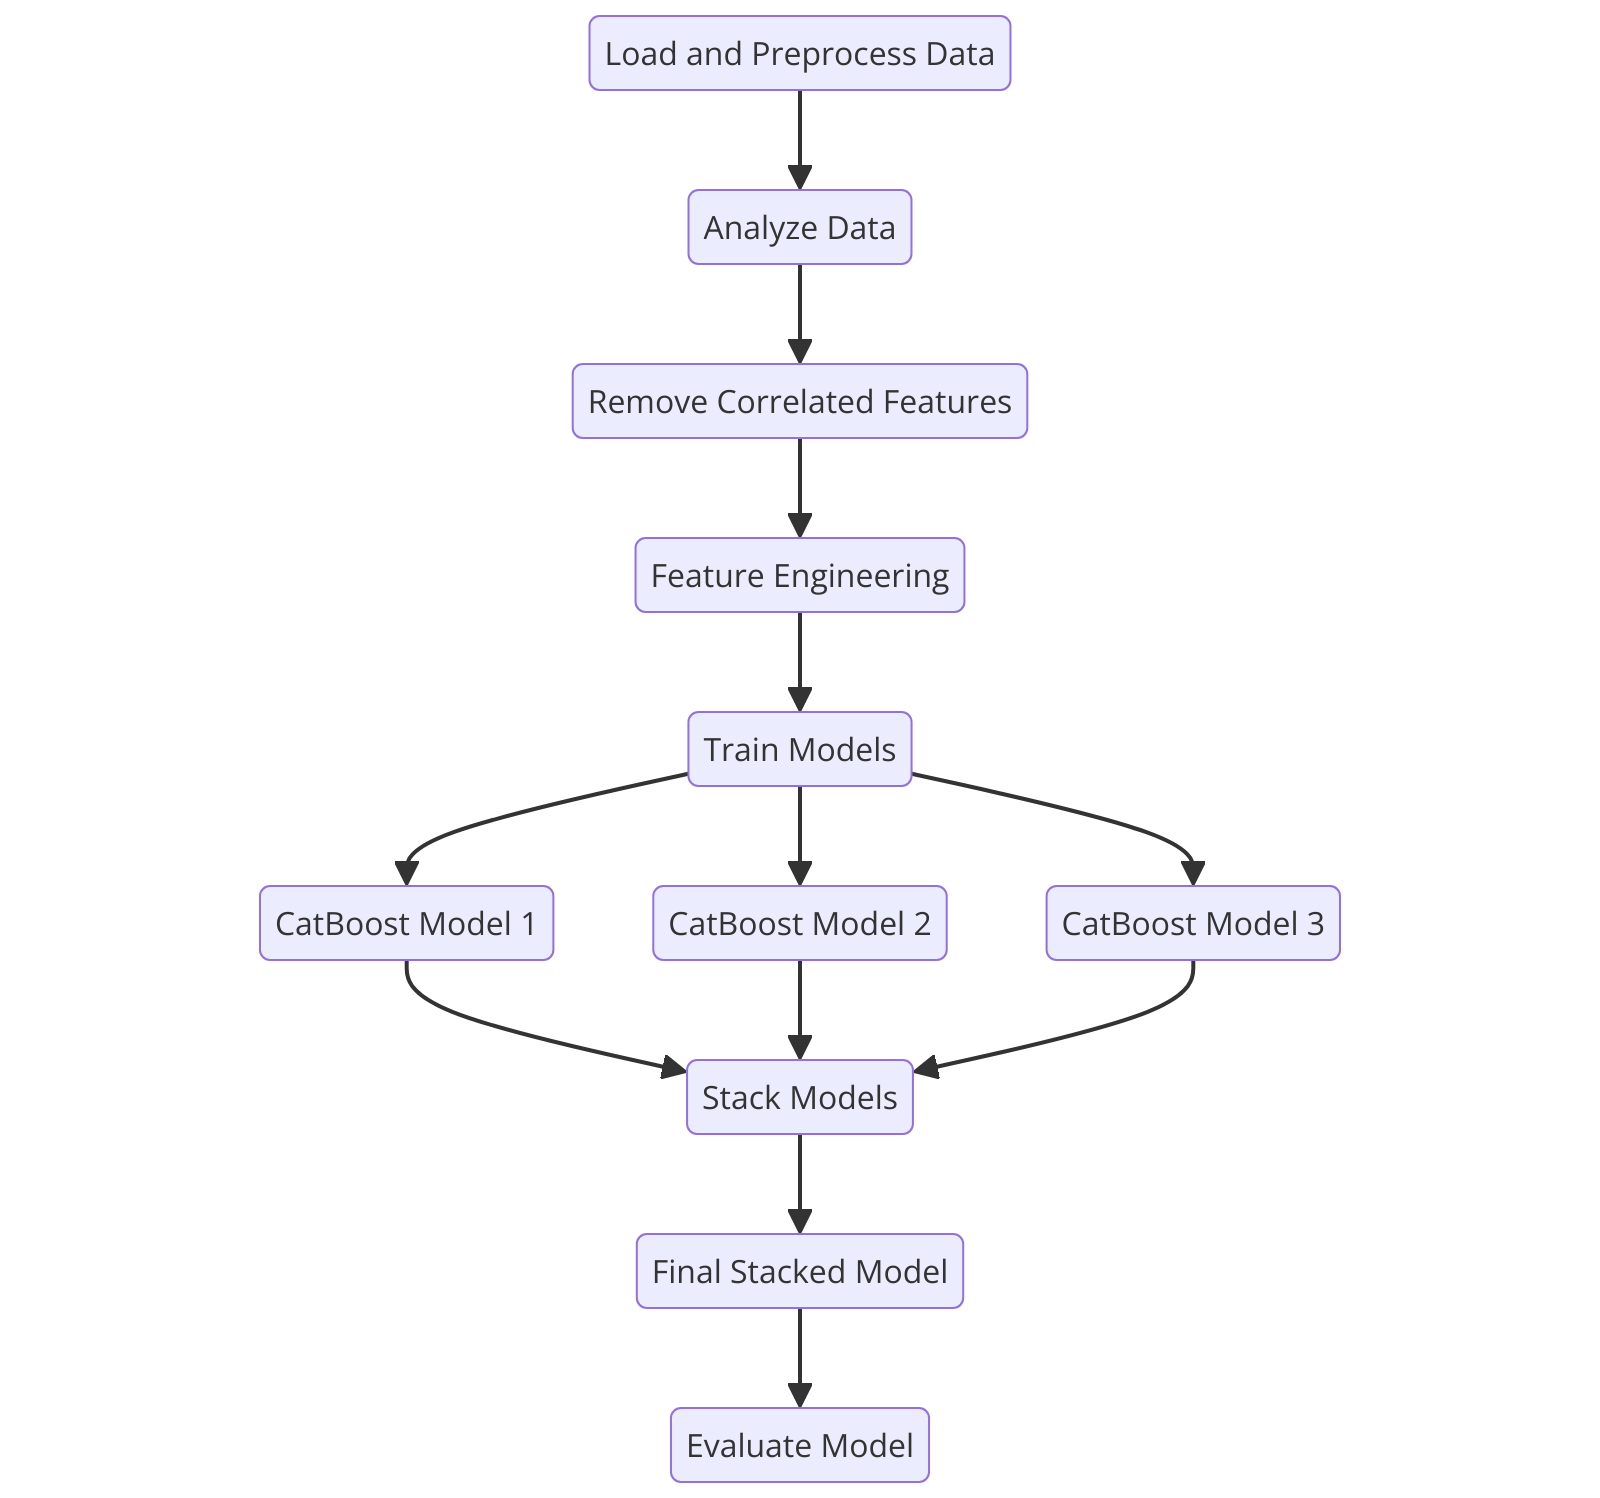